In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from mpl_toolkits.mplot3d import Axes3D
import os
import glob
import madmom

from essentia import *
from essentia.standard import *

def getListOfFiles(path, filterPattern=""):
    """Get list of wav files (or mp3s) in a folder

    :param path: directory containing soundfiles

    :return: a list of file names

    """
    files = []

    #For the recursive functionality we need a list of paths
    if type(path) is not list:
        path = [path]

    for f in path:
        # check what we have (file/path)
        if os.path.isdir(f):
            # use all files in the given path
            files = glob.glob(f + '/' + filterPattern)        
        else:
            # file was given, append to list
            files.append(f)
        
    return files

def extractor(timbreClass):    
    audio = MonoLoader(filename=timbreClass, sampleRate=44100)()

    lowLevelSpectralExtractor = LowLevelSpectralExtractor()
    
    out = lowLevelSpectralExtractor(audio)
    
    pool = essentia.Pool()
    
    tristimulus = out[-2]
    
    for row in tristimulus:
        pool.add("tristimulus", row)
    
    # compute mean and variance of the frames
    aggrPool = PoolAggregator(defaultStats = [ 'mean', 'var' ])(pool)
    
    return aggrPool['tristimulus.mean']

def normaliseFeatures(features):
    maxs = [-np.inf, -np.inf, -np.inf]
    mins = [np.inf, np.inf, np.inf]
    
    for featureClass in features:
        for feature in features[featureClass]:
            for i in range(3):
                if feature[i] < mins[i]:
                    mins[i] = feature[i]
                if feature[i] > maxs[i]:
                    maxs[i] = feature[i]
                    
    print maxs
    print mins
                
    for featureClass in features:
        for feature in features[featureClass]:
            for i in range(3):
                x = feature[i]
            
                z = (x - mins[i]) / (maxs[i] - mins[i])
            
                feature[i] = z
            
def extractFeatures(path):
    # load our audio into an array
    files = getListOfFiles(path, filterPattern="*.mp3")
    files = files + (getListOfFiles(path, filterPattern="*.wav"))
    
    features = []
    
    for file in files:
#         note = file.split("/")[-1]
#         print note
#         note = note.split("_")[1]
#         print(note)
        
        features.append(extractor(file))
    
    return features        

In [2]:
timbreClasses = ["strings", "winds", "perc"]

features = {}

rootPath = "/Users/carthach/Google Drive/Code/thesis_plots/timbre/samples/"

for timbreClass in timbreClasses:
    features[timbreClass] = extractFeatures(rootPath + timbreClass)
    features[timbreClass] = np.array(features[timbreClass])

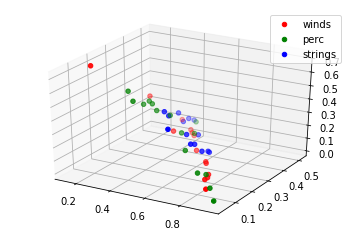

In [3]:
def plotClass(ax, features, color="", label=""):
    ax.scatter(features[:,0], features[:,1], features[:,2], color=color, label=label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
    
colours = ['r', 'g', 'b']

i = 0
for timbreClass in features:
    plotClass(ax,features[timbreClass], colours[i], timbreClass)
        
    i = i + 1
    
plt.legend()
plt.savefig("tristimulus.pdf", bbox_inches='tight', dpi=1200)
plt.show()
